In [38]:
# !pip install pdf2image
# !sudo apt install poppler-utils
# !sudo apt-get update
# !sudo apt-get install tesseract-ocr -y

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]      
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [59.5 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [3,413 kB]
Hit:9 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 https://packagecloud.io/github/git-lfs/ubuntu jammy InRelease [29.2 kB]  
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3,323 kB]
Get:11 https://packagecloud.io/github/git-lfs/ubuntu jammy/main amd64 Packages [2,026 B]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [52.2 kB]
Get:13 http

In [39]:
import pytesseract
import torch

from pdf2image import convert_from_path
from torchvision import transforms
from transformers import AutoModelForObjectDetection

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
model = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-detection", revision="no_timm")
model.to(device)

TableTransformerForObjectDetection(
  (model): TableTransformerModel(
    (backbone): TableTransformerConvModel(
      (conv_encoder): TableTransformerConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): TableTransformerFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBasicLayer(
                    (shortcut): Identity()
                    (layer): Sequential(
                      (0): ResNetConvLayer(
                        (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(

In [5]:
images = convert_from_path("sample.pdf")

In [9]:
image = images[0]

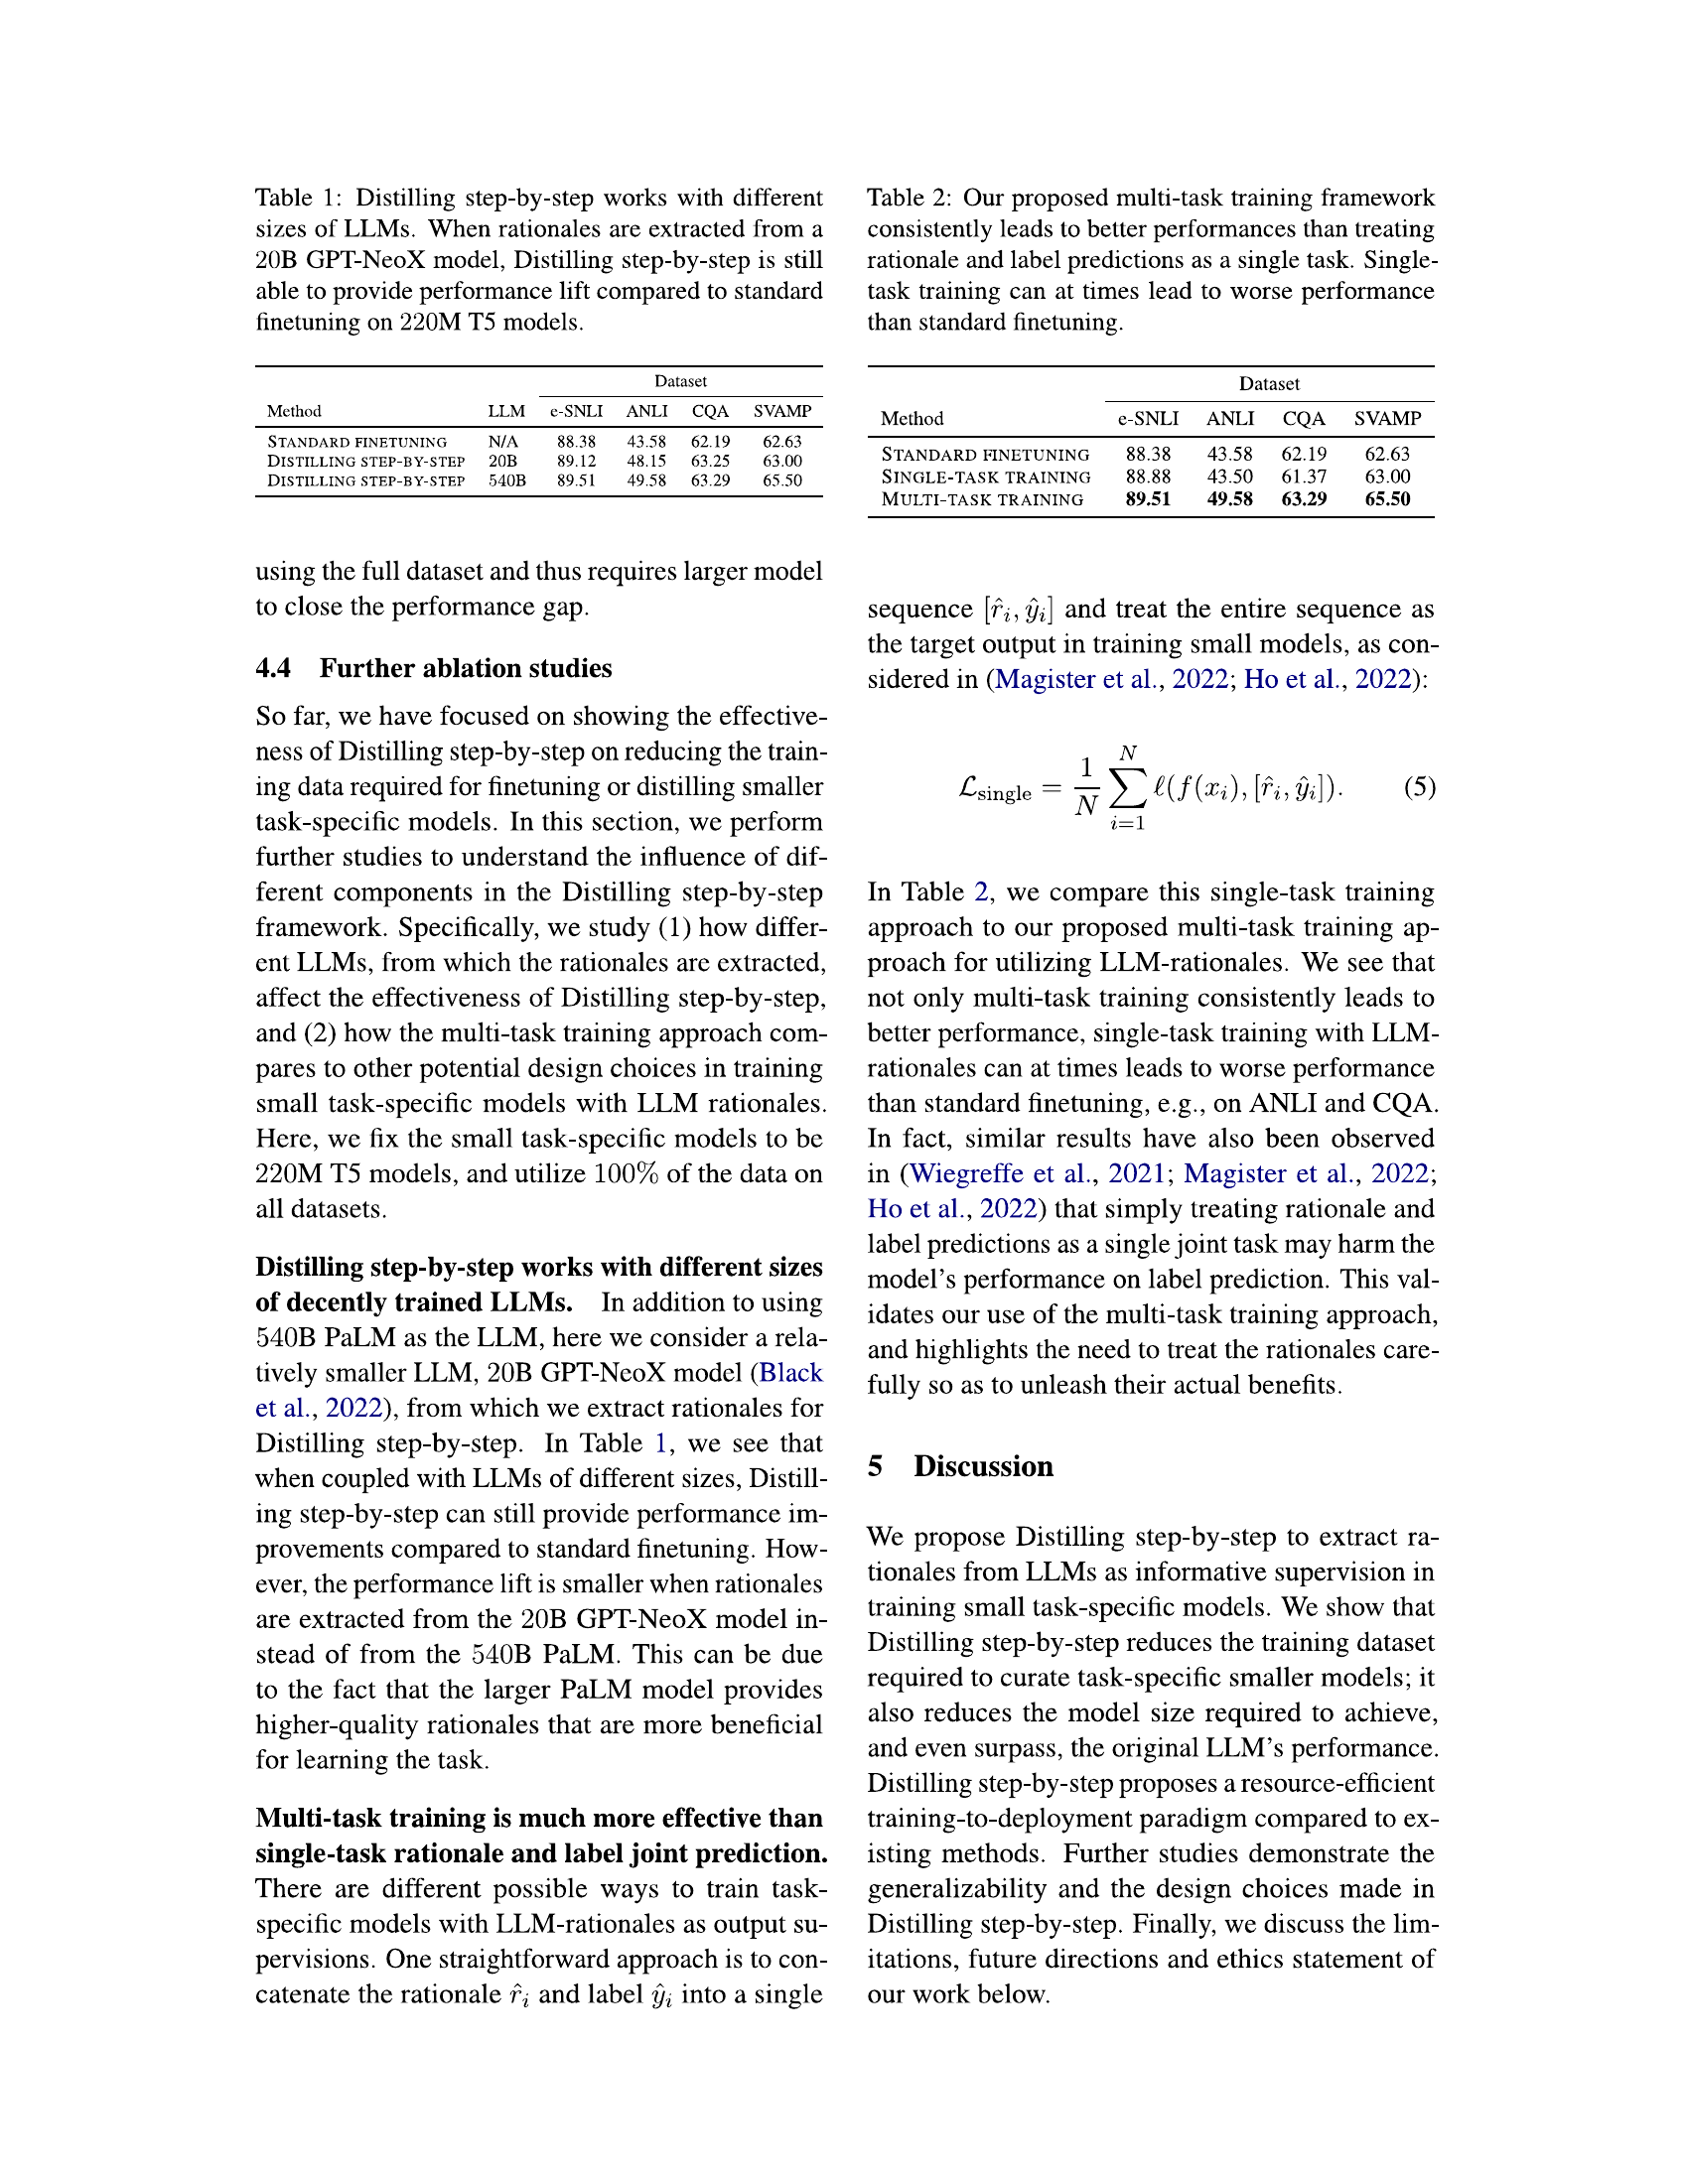

In [10]:
image

In [40]:
# Perform OCR
text = pytesseract.image_to_string(image)

print("Extracted Text:")
print(text)

Extracted Text:
Table 1: Distilling step-by-step works with different
sizes of LLMs. When rationales are extracted from a
20B GPT-NeoX model, Distilling step-by-step is still
able to provide performance lift compared to standard
finetuning on 220M TS models.

Table 2: Our proposed multi-task training framework
consistently leads to better performances than treating
rationale and label predictions as a single task. Single-
task training can at times lead to worse performance
than standard finetuning.

 

Dataset
ANLI CQA  SVAMP

STANDARD FINETUNING NIA 88.38 43.58 62.19 62.63
DISTILLING STEP-BY-STEP 20B 89.12 48.15 63.25 63.00
DISTILLING STEP-BY-STEP 540B 89.51 49.58 63.29 65.50

Method LLM_se-SNLI

 

 

using the full dataset and thus requires larger model
to close the performance gap.

4.4 Further ablation studies

So far, we have focused on showing the effective-
ness of Distilling step-by-step on reducing the train-
ing data required for finetuning or distilling smaller
task-specif

In [14]:
class MaxResize(object):
    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize((int(round(scale*width)), int(round(scale*height))))

        return resized_image

In [15]:
detection_transform = transforms.Compose([
    MaxResize(800),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406], 
        [0.229, 0.224, 0.225]
    )
])

In [16]:
pixel_values = detection_transform(image).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 800, 618])


In [17]:
# forward pass
with torch.no_grad():
    outputs = model(pixel_values)

In [20]:
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def outputs_to_objects(outputs, img_size, id2label):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == 'no object':
            objects.append({
                'label': class_label, 
                'score': float(score),
                'bbox': [float(elem) for elem in bbox]
            })

    return objects

In [21]:
# update id2label to include "no object"
id2label = model.config.id2label
id2label[len(model.config.id2label)] = "no object"

objects = outputs_to_objects(outputs, image.size, id2label)
print(objects)

[{'label': 'table', 'score': 0.9992978572845459, 'bbox': [259.82855224609375, 366.5050048828125, 808.9972534179688, 494.3616638183594]}, {'label': 'table', 'score': 0.9992409944534302, 'bbox': [886.4044799804688, 369.4547424316406, 1434.0462646484375, 513.4415283203125]}]


In [22]:
def objects_to_crops(img, tokens, objects, class_thresholds, padding=10):
    """
    Process the bounding boxes produced by the table detection model into
    cropped table images and cropped tokens.
    """

    table_crops = []
    for obj in objects:
        if obj['score'] < class_thresholds[obj['label']]:
            continue

        cropped_table = {}

        bbox = obj['bbox']
        bbox = [bbox[0]-padding, bbox[1]-padding, bbox[2]+padding, bbox[3]+padding]

        cropped_img = img.crop(bbox)

        table_tokens = [token for token in tokens if iob(token['bbox'], bbox) >= 0.5]
        for token in table_tokens:
            token['bbox'] = [
                token['bbox'][0]-bbox[0],
                token['bbox'][1]-bbox[1],
                token['bbox'][2]-bbox[0],
                token['bbox'][3]-bbox[1]
            ]

        # If table is predicted to be rotated, rotate cropped image and tokens/words:
        if obj['label'] == 'table rotated':
            cropped_img = cropped_img.rotate(270, expand=True)
            for token in table_tokens:
                bbox = token['bbox']
                bbox = [
                    cropped_img.size[0]-bbox[3]-1,
                    bbox[0],
                    cropped_img.size[0]-bbox[1]-1,
                    bbox[2]
                ]
                token['bbox'] = bbox

        cropped_table['image'] = cropped_img
        cropped_table['tokens'] = table_tokens

        table_crops.append(cropped_table)

    return table_crops

In [24]:
tokens = []
detection_class_thresholds = {
    "table": 0.5,
    "table rotated": 0.5,
    "no object": 10
}

tables_crops = objects_to_crops(image, tokens, objects, detection_class_thresholds, padding=0)

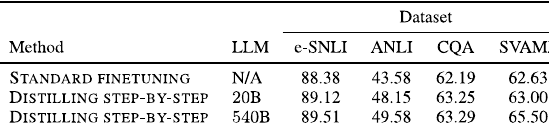

In [25]:
cropped_table1 = tables_crops[0]['image'].convert("RGB")
cropped_table1

In [28]:
cropped_table1.save("example1.jpg", "JPEG")

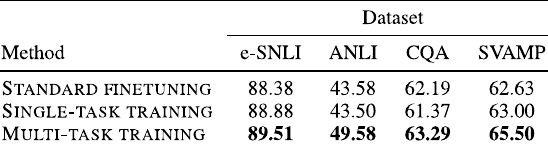

In [27]:
cropped_table2 = tables_crops[1]['image'].convert("RGB")
cropped_table2

In [29]:
cropped_table2.save("example2.jpg", "JPEG")